<h1><center>INTRODUCTION</center></h1>

<h3><center>PROBLEM STATEMENT</center></h3>
<ul>
    <li>Semantic Textual Similarity is a job in Natural Language Processing (NLP) that
    uses a predetermined metric to score the relationship between texts or documents.</li>
    <li>This model recognizes the similarity between two pieces of text or documents and 
        determining how similar two pieces of texts are.</li>
    <li>This can take the form of assigning a score from 0 to 4.</li>
    
</ul>

<h1><center>OVERVIEW</center></h1>

<ul>
    <li>We have used the Stanford's SemEval2014 task-3 Dataset<br> <a href="https://alt.qcri.org/semeval2014/task3/index.php?id=data-and-tools">Link to Dataset</a></li>
    <li>The model can check similarity between 3 Lexical levels </li>
    <ul>
        <li>Paragraph to sentence,</li>
        <li>Sentence to Phrase</li>
        <li>Phrase to Word</li>
    </ul>
        <li>Five-point rating scale designed to capture to similarity of the 
            small lexical item's semantics within the semantics of the larger semantic unit.</li>
    <li>We used BERT(Bi-Directional Encoder Representations from Transformers) to train the model.</li>
    <li>We then passed the output of BERT to our model made of Bi-Directional LSTMs.</li>
</ul>

<h1><center>METHOD</center></h1>

<h1><center>IMPORTING LIBRARIES</center></h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


import transformers
import tensorflow as tf
from utils import BertSemanticDataGenerator
from random import randint


from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

<h1><center>DIRECTORIES AND HYPERPARAMETRERS</center></h1>

In [2]:
P2S_TRAIN_INPUT_DIR = "SemEval-2014_Task-3/data/training/paragraph2sentence.train.input.tsv"
P2S_TRAIN_KEYS_DIR = "SemEval-2014_Task-3/keys/training/paragraph2sentence.train.gs.tsv"
P2S_VALID_INPUT_DIR = "SemEval-2014_Task-3/data/trial/paragraph2sentence.trial.input.tsv"
P2S_VALID_KEYS_DIR = "SemEval-2014_Task-3/keys/trial/paragraph2sentence.trial.gs.tsv"
P2S_TEST_INPUT_DIR = "SemEval-2014_Task-3/data/test/paragraph2sentence.test.input.tsv"
P2S_TEST_KEYS_DIR = "SemEval-2014_Task-3/keys/test/paragraph2sentence.test.gs.tsv"

S2P_TRAIN_INPUT_DIR = "SemEval-2014_Task-3/data/training/sentence2phrase.train.input.tsv"
S2P_TRAIN_KEYS_DIR = "SemEval-2014_Task-3/keys/training/sentence2phrase.train.gs.tsv"
S2P_VALID_INPUT_DIR = "SemEval-2014_Task-3/data/trial/sentence2phrase.trial.input.tsv"
S2P_VALID_KEYS_DIR = "SemEval-2014_Task-3/keys/trial/sentence2phrase.trial.gs.tsv"
S2P_TEST_INPUT_DIR = "SemEval-2014_Task-3/data/test/sentence2phrase.test.input.tsv"
S2P_TEST_KEYS_DIR = "SemEval-2014_Task-3/keys/test/sentence2phrase.test.gs.tsv"

P2W_TRAIN_INPUT_DIR = "SemEval-2014_Task-3/data/training/phrase2word.train.input.tsv"
P2W_TRAIN_KEYS_DIR = "SemEval-2014_Task-3/keys/training/phrase2word.train.gs.tsv"
P2W_VALID_INPUT_DIR = "SemEval-2014_Task-3/data/trial/phrase2word.trial.input.tsv"
P2W_VALID_KEYS_DIR = "SemEval-2014_Task-3/keys/trial/phrase2word.trial.gs.tsv"
P2W_TEST_INPUT_DIR = "SemEval-2014_Task-3/data/test/phrase2word.test.input.tsv"
P2W_TEST_KEYS_DIR = "SemEval-2014_Task-3/keys/test/phrase2word.test.gs.tsv"


max_length = 256
batch_size = 32
EPOCHS = 10
labels = [0,1,2,3,4]

<h1><center> CLEANING AND LOADING DATA </center></h1>

In [3]:
def data_prep(train_dir , train_keys_dir , valid_dir, valid_keys_dir ,test_dir , test_keys_dir , to_int = True):
    
    train_data = pd.read_csv(train_dir,sep='\t', header = None , names = ["SEQ-1", "SEQ-2" ,"Travel"])
    del train_data["Travel"]
    train_keys = pd.read_csv(train_keys_dir,sep='\t' , header = None , names = ["key"])
    if to_int:
        train_keys = train_keys.round().astype("int")
    train_data["Keys"] = train_keys
    
    valid_data = pd.read_csv(valid_dir,sep='\t', header = None , names = ["SEQ-1", "SEQ-2" ,"Travel"])
    del valid_data["Travel"]
    valid_keys = pd.read_csv(valid_keys_dir,sep='\t' , header = None , names = ["key"])
    if to_int:
        valid_keys = valid_keys.round().astype("int")
    valid_data["Keys"] = valid_keys
    
    test_data = pd.read_csv(test_dir,sep='\t', header = None , names = ["SEQ-1", "SEQ-2" ,"Travel"])
    del test_data["Travel"]
    test_keys = pd.read_csv(test_keys_dir,sep='\t' , header = None , names = ["key"])
    if to_int:
        test_keys = test_keys.round().astype("int")
    test_data["Keys"] = test_keys
    
    return (train_data , valid_data , test_data)
    
def data_concat(p2s, s2p , p2w ):
    
    train = pd.concat([p2s[0] ,  s2p[0] , p2w[0] ] , ignore_index=True)
    valid = pd.concat([p2s[1] ,  s2p[1] , p2w[1] ] , ignore_index=True)
    test  = pd.concat([p2s[2] ,  s2p[2] , p2w[2] ] , ignore_index=True)
    
    return train , valid , test 

In [4]:
p2s = data_prep(P2S_TRAIN_INPUT_DIR ,
                P2S_TRAIN_KEYS_DIR , 
                P2S_VALID_INPUT_DIR , 
                P2S_VALID_KEYS_DIR ,
                P2S_TEST_INPUT_DIR ,
                P2S_TEST_KEYS_DIR)
s2p = data_prep(S2P_TRAIN_INPUT_DIR ,
                S2P_TRAIN_KEYS_DIR , 
                S2P_VALID_INPUT_DIR , 
                S2P_VALID_KEYS_DIR ,
                S2P_TEST_INPUT_DIR ,
                S2P_TEST_KEYS_DIR)
p2w = data_prep(P2W_TRAIN_INPUT_DIR ,
                P2W_TRAIN_KEYS_DIR , 
                P2W_VALID_INPUT_DIR , 
                P2W_VALID_KEYS_DIR ,
                P2W_TEST_INPUT_DIR ,
                P2W_TEST_KEYS_DIR)

train_data , valid_data , test_data = data_concat(p2s, s2p , p2w )

In [5]:
train_data

,SEQ-1,SEQ-2,Keys
0,"Little St-Julien-le-Pauvre, a jewel of early G...",Bricks fired on the spot are the valley’s main...,0
1,Next to the castle is the impressive Gothic Sé...,"During the Crusades, Portuguese Crusaders ofte...",3
2,Manzanillo initially drew the interest of inte...,"Nearby, on Calle Pío Rosado, the Museo Emilio ...",0
3,Alongside a landmark water tower is a good ope...,"Following a Mongol invasion, King Belá IV made...",2
4,Most beaches protected from the open ocean hav...,Boat cruises offer a care free way to enjoy th...,3
...,...,...,...
1495,restrictions on foreign investments,collectables,0
1496,dangerous products that have been marketed,products,2
1497,pounds to us dollars,exchange,4
1498,the guy who calls me beautiful instead of hot,compliments,2


<AxesSubplot:>

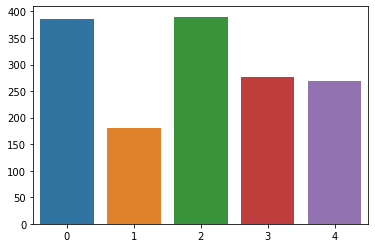

In [6]:
sns.barplot(x = np.unique(train_data["Keys"]),
             y =  [list(train_data["Keys"]).count(i) for i in np.unique(train_data["Keys"])])

<AxesSubplot:>

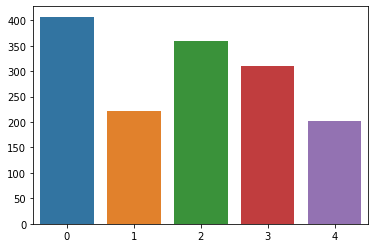

In [7]:
sns.barplot(x = np.unique(test_data["Keys"]),
             y =  [list(test_data["Keys"]).count(i) for i in np.unique(train_data["Keys"])])

<AxesSubplot:>

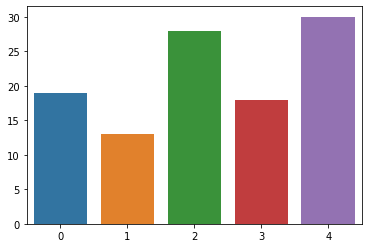

In [8]:
sns.barplot(x = np.unique(valid_data["Keys"]),
             y =  [list(valid_data["Keys"]).count(i) for i in np.unique(train_data["Keys"])])

<h1><center>DATA PREPROCESSING</center></h1>


In [9]:
y_train = tf.keras.utils.to_categorical(train_data["Keys"] , num_classes= 5 )
y_test = tf.keras.utils.to_categorical(test_data["Keys"] , num_classes= 5 )
y_valid = tf.keras.utils.to_categorical(valid_data["Keys"] , num_classes= 5 )

<h1><center> LOADING DATA BATCHES </center></h1>

In [10]:
train = BertSemanticDataGenerator(
    train_data[["SEQ-1", "SEQ-2"]].values.astype("str"),
    y_train,
    batch_size=batch_size,
    shuffle=True,
)
valid = BertSemanticDataGenerator(
    valid_data[["SEQ-1", "SEQ-2"]].values.astype("str"),
    y_valid,
    batch_size=batch_size,
    shuffle=False,
)
test = BertSemanticDataGenerator(
    test_data[["SEQ-1", "SEQ-2"]].values.astype("str"),
    y_test,
    batch_size=batch_size,
    shuffle=False,
)

<h1><center>MODEL</center></h1>

In [11]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    input_ids = tf.keras.layers.Input(shape=(max_length,), 
                                      dtype=tf.int32, 
                                      name="input_ids")
    attention_masks = tf.keras.layers.Input(shape=(max_length,), 
                                            dtype=tf.int32, 
                                            name="attention_masks")
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), 
                                           dtype=tf.int32, 
                                           name="token_type_ids")
    
    bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased")
    bert_model.trainable = False

    sequence_output, pooled_output = bert_model(input_ids, 
                                                attention_mask=attention_masks, 
                                                token_type_ids=token_type_ids)
    bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(sequence_output)
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
    concat = tf.keras.layers.concatenate([avg_pool, max_pool])
    dropout = tf.keras.layers.Dropout(0.3)(concat)
    output = tf.keras.layers.Dense(5, activation="softmax")(dropout)
    model = tf.keras.models.Model(inputs=[input_ids, attention_masks, token_type_ids], 
                                  outputs=output)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["acc"],
    )

clear_output()


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
attention_masks (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 256, 768), ( 109482240   input_ids[0][0]                  
______________________________________________________________________________________________

<h1><center> TRAINING THE MODEL </center></h1>

In [13]:
history = model.fit(
    train,
    epochs=EPOCHS,
    use_multiprocessing=True,
    workers=-1,
)
history = pd.DataFrame(history.history)

  ...
    to  
  ['...']
Train for 46 steps
Epoch 1/10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
46/46 [==============================] - 64s 1s/step - loss: 1.5704 - acc: 0.3139
Epoch 2/10
46/46 [==============================] - 44s 954ms/step - loss: 1.3483 - acc: 0.4355
Epoch 3/10
46/46 [==============================] - 43s 945ms/step - loss: 1.2173 - acc: 0.4864
Epoch 4/10
46/46 [==============================] - 45s 973ms/step - loss: 1.1237 - acc: 0.5421
Epoch 5/10
46/4

<h1><center>RESULTS</center></h1>

<h3><center> TRAINING ACCURACY GRAPH </center></h3>

ERROR! Session/line number was not unique in database. History logging moved to new session 1143


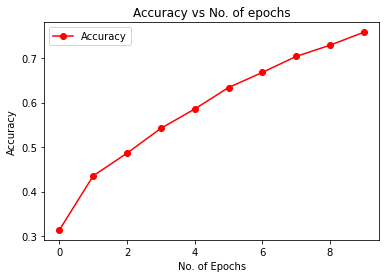

In [14]:
plt.plot(history["acc"], label= "Accuracy" , color = 'r'  , marker = 'o' )
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs No. of epochs")
plt.legend();

<h3><center> TRAINING LOSS GRAPH </center></h3>

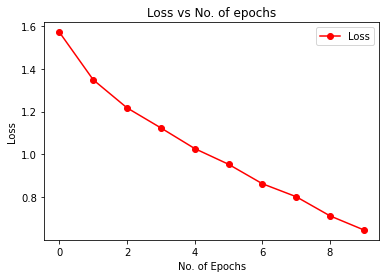

In [15]:
plt.plot(history["loss"], label= "Loss" , color= 'r', marker = 'o' )
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.title("Loss vs No. of epochs")
plt.legend();

In [16]:
model.evaluate(test, verbose=1)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


46/46 [==============================] - 41s 895ms/step - loss: 1.3511 - acc: 0.4857


[1.3510682919751043, 0.4857337]

<h1><center> EVALUATING MODEL </center></h1>

In [17]:
def check_similarity():
    index = randint(1,1500)
    seq1 = test_data["SEQ-1"][index]
    seq2 = test_data["SEQ-2"][index]
    key = test_data["Keys"][index]
    sentence_pairs = np.array([[str(seq1), str(seq2)]])
    test_data_1 = BertSemanticDataGenerator(
        sentence_pairs, labels=None, batch_size=1, shuffle=False, include_targets=False,
    )

    proba = model.predict(test_data_1)[0]
    idx = np.argmax(proba)
    proba = f"{proba[idx]: .2f}%"
    pred = labels[idx]
    return (seq1 , seq2 , key ,pred, proba)

In [40]:
seq1,seq2, key, pred, prob = check_similarity()
clear_output()

print("Sequence 1 :", seq1 )
print()
print("Sequence 2 " ,seq2)
print()
print("Orignal Key:" ,key)
print("Predicted Key",pred)
print("Probability of Prediction" , prob)

Sequence 1 : Do I really Need internet explorer in my windows? I use firefox more than often (safer). Is it ok to just deinstall internet explorer?

Sequence 2  When using a safer, better web browser such as Firefox, is it possible to uninstall others such as Internet Explorer?

Orignal Key: 3
Predicted Key 3
Probability of Prediction  0.90%
